In [1]:
# --- SETUP ---
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, clone_model


import joblib
import json
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import model_from_json
import json

# Updated KerasRegressorWrapper
from tensorflow.keras.models import save_model, load_model
import tempfile
import os

# Set random seed for reproducibility
np.random.seed(42)

# List of tickers to process
TICKERS = ["AAPL", "JPM", "AMZN", "PFE", "XOM"]
N_FOLDS = 5


In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def direction_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

def sharpe_ratio(returns, risk_free_rate=0):
    excess = returns - risk_free_rate
    if np.std(excess) == 0:
        return 0.0
    return np.mean(excess) / (np.std(excess) + 1e-9) * np.sqrt(252)

def buy_and_hold_return(test_df):
    returns = np.log(test_df['close'] / test_df['close'].shift(1)).fillna(0)
    return returns

def model_return(y_pred, y_true, test_df):
    # Assume prediction >0 means long, <0 means short
    side = np.where(y_pred > 0, 1, -1)
    returns = np.log(test_df['close'] / test_df['close'].shift(1)).fillna(0)
    strategy_returns = returns * side
    return strategy_returns


In [3]:
results = []  # Store results for aggregation


In [4]:
def build_technical_model(input_shape):
    """Model builder function that returns a fresh compiled model"""
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64,
             activation='tanh',
             recurrent_activation='sigmoid',
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             kernel_constraint=MaxNorm(3),
             recurrent_constraint=MaxNorm(3)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_fundamental_model(X_train, y_train):
    """XGBoost model for fundamentals"""
    model = XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        objective='reg:squarederror'
    )
    model.fit(X_train, y_train)
    return model

def train_technical_model(X_train, y_train, X_test, y_test):
    """Train LSTM model with proper initialization and gradient control"""
    # Normalize targets
    y_mean, y_std = y_train.mean(), y_train.std()
    y_train_norm = (y_train - y_mean) / y_std
    y_test_norm = (y_test - y_mean) / y_std
    
    # Build and compile model
    model = build_technical_model((X_train.shape[1], X_train.shape[2]))
    model.compile(
        optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
        loss='mse',
        metrics=['mae']
    )
    
    # Train with callbacks
    history = model.fit(
        X_train, y_train_norm,
        validation_data=(X_test, y_test_norm),
        epochs=50,
        batch_size=32,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ],
        verbose=1
    )
    
    # Store normalization parameters
    model.y_mean = y_mean
    model.y_std = y_std
    
    return model




Processing AAPL ...
Fold 1: Training LSTM ...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 0.9203 - mae: 0.7292 - val_loss: 1.5603 - val_mae: 1.0104 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.7510 - mae: 0.6570 - val_loss: 1.2839 - val_mae: 0.8831 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.6279 - mae: 0.5989 - val_loss: 1.1522 - val_mae: 0.8173 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.6969 - mae: 0.6392 - val_loss: 1.0740 - val_mae: 0.7841 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.5557 - mae: 0.5740 - val_loss: 1.0532 - val_mae: 0.7758 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.6267 - mae: 0.6267 - val_loss: 1.0418 - val_mae: 0.7736 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.5514 - mae: 0.5808 - val_loss: 1.0427 - val_mae: 0.7749 - le

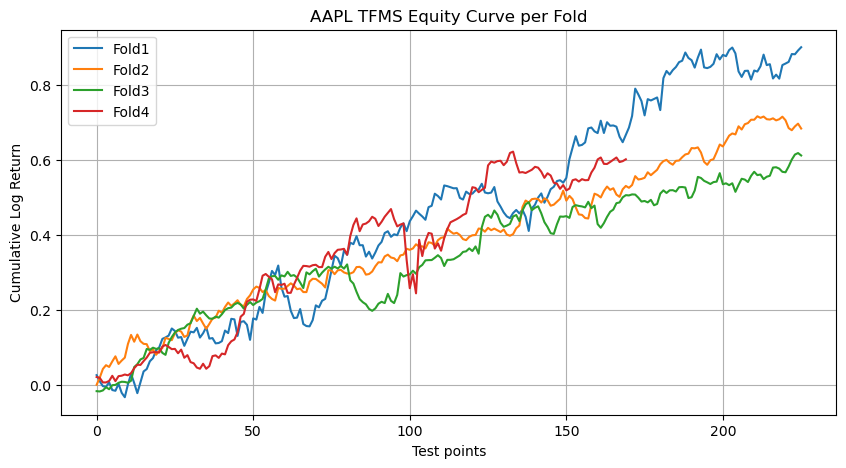

Processing JPM ...
Fold 1: Training LSTM ...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.8318 - mae: 0.6560 - val_loss: 1.5801 - val_mae: 0.9827 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.6563 - mae: 0.5998 - val_loss: 1.2829 - val_mae: 0.8618 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.5497 - mae: 0.5497 - val_loss: 1.1818 - val_mae: 0.8232 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.5191 - mae: 0.5436 - val_loss: 1.1824 - val_mae: 0.8423 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.5786 - mae: 0.5717 - val_loss: 1.2191 - val_mae: 0.8662 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.5551 - mae: 0.5611 - val_loss: 1.1566 - val_mae: 0.8414 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.5707 - mae: 0.5702 - val_loss: 1.0778 - val_mae: 0.8026 - lea

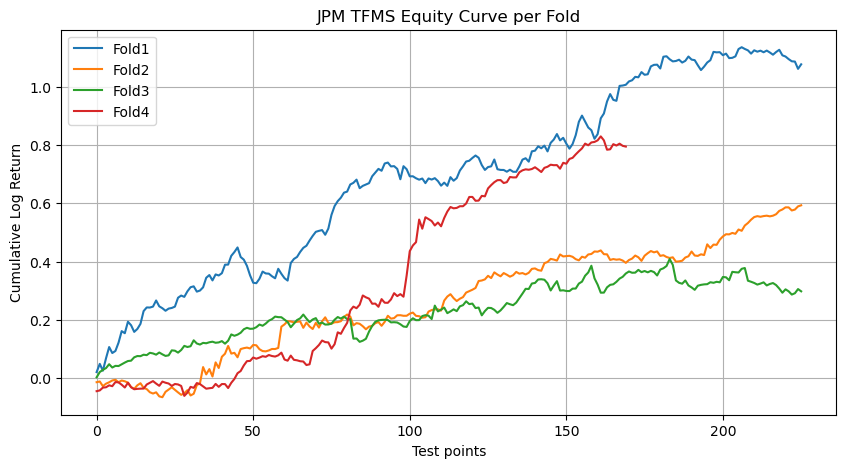

Processing AMZN ...
Fold 1: Training LSTM ...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - loss: 1.0041 - mae: 0.7471 - val_loss: 2.9420 - val_mae: 1.2842 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6981 - mae: 0.6382 - val_loss: 2.7869 - val_mae: 1.2416 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6600 - mae: 0.6303 - val_loss: 2.8019 - val_mae: 1.2477 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6579 - mae: 0.6430 - val_loss: 2.7895 - val_mae: 1.2460 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.5896 - mae: 0.6093 - val_loss: 2.9416 - val_mae: 1.2956 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.6252 - mae: 0.6141 - val_loss: 2.8149 - val_mae: 1.2615 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.6293 - mae: 0.6234 - val_loss: 2.8929 - val_mae: 1.2970 - le

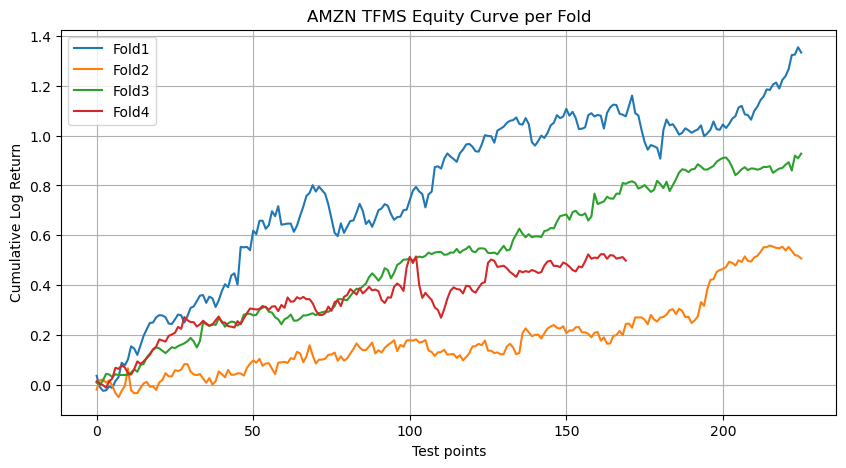

Processing PFE ...
Fold 1: Training LSTM ...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.9273 - mae: 0.7174 - val_loss: 0.6767 - val_mae: 0.6433 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6802 - mae: 0.5780 - val_loss: 0.5644 - val_mae: 0.5836 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5753 - mae: 0.5560 - val_loss: 0.5408 - val_mae: 0.5790 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6588 - mae: 0.5785 - val_loss: 0.5530 - val_mae: 0.5863 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.6587 - mae: 0.5773 - val_loss: 0.5861 - val_mae: 0.6099 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.5081 - mae: 0.5120 - val_loss: 0.6192 - val_mae: 0.6311 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.5733 - mae: 0.5368 - val_loss: 0.6227 - val_mae: 0.6383 - lea

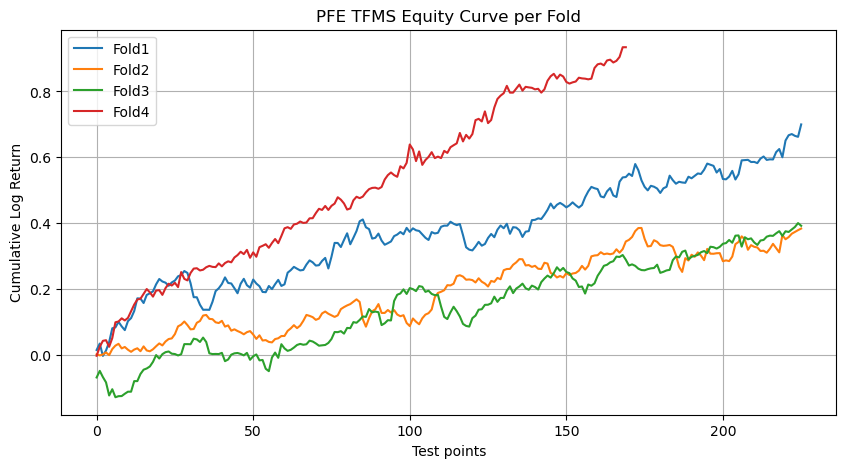

Processing XOM ...
Fold 1: Training LSTM ...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 0.9972 - mae: 0.7655 - val_loss: 1.4559 - val_mae: 0.8817 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.6744 - mae: 0.6272 - val_loss: 1.3721 - val_mae: 0.8549 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5691 - mae: 0.5848 - val_loss: 1.4170 - val_mae: 0.8913 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.5662 - mae: 0.5935 - val_loss: 1.6199 - val_mae: 0.9818 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.5738 - mae: 0.5792 - val_loss: 1.6504 - val_mae: 0.9939 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.5103 - mae: 0.5539 - val_loss: 1.4377 - val_mae: 0.9044 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.5456 - mae: 0.5843 - val_loss: 1.3623 - val_mae: 0.8736 - lea

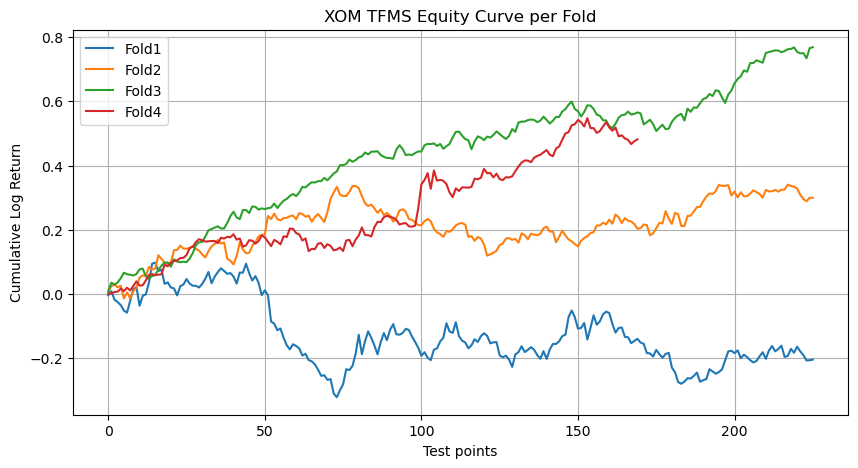

In [5]:
for ticker in TICKERS:
    print("="*50)
    print(f"Processing {ticker} ...")
    data_path = f"../data/processed/integrated/{ticker}_integrated.csv"
    df = pd.read_csv(data_path)
    
    technical_features = ['RSI_14', 'SMA_20', 'Volume']
    fundamental_features = ['debt_to_equity', 'sentiment_3day_ma']  # edit if yours differ
    target_col = 'target_5day_return'
    lookback = 60
    n_features = len(technical_features)
    n_fund_features = len(fundamental_features)

    fold_size = len(df) // N_FOLDS
    fold_metrics = {"ticker": [], "model": [], "fold": [], "RMSE": [], "Accuracy": [], "Sharpe": []}
    all_equity_curves = {}

    # Rolling window creation function, in-notebook for clarity
    def create_rolling_tech_sequences(dataf, tech_feats, target, lb=60):
        n_samples = len(dataf) - lb + 1
        n_feat = len(tech_feats)
        X_tech = np.zeros((n_samples, lb, n_feat))
        y_seq = np.zeros(n_samples)
        for i in range(n_samples):
            X_tech[i] = dataf[tech_feats].iloc[i:i+lb].values
            y_seq[i] = dataf[target].iloc[i+lb-1]
        return X_tech, y_seq

    for fold in range(N_FOLDS):
        split = fold_size * (fold + 1)
        if split + lookback - 1 > len(df):
            print(f"Skipping final fold {fold+1} (not enough data left for lookback window).")
            break
        
        train_df = df.iloc[:split + lookback - 1].copy()
        test_df = df.iloc[split:split + fold_size + lookback - 1].copy()

        # Build LSTM (technical) rolling sequences & target
        X_train_tech, y_train = create_rolling_tech_sequences(train_df, technical_features, target_col, lookback)
        X_test_tech, y_test = create_rolling_tech_sequences(test_df, technical_features, target_col, lookback)
        
        # Feature scaling for LSTM
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train_tech_flat = X_train_tech.reshape(-1, n_features)
        X_train_tech_scaled_flat = scaler.fit_transform(X_train_tech_flat)
        X_train_tech_scaled = X_train_tech_scaled_flat.reshape(X_train_tech.shape)
        X_test_tech_flat = X_test_tech.reshape(-1, n_features)
        X_test_tech_scaled_flat = scaler.transform(X_test_tech_flat)
        X_test_tech_scaled = X_test_tech_scaled_flat.reshape(X_test_tech.shape)

        # Fundamental features, aligned to tech/y
        X_train_fund = train_df[fundamental_features].iloc[lookback-1:lookback-1+len(y_train)].to_numpy()
        X_test_fund = test_df[fundamental_features].iloc[lookback-1:lookback-1+len(y_test)].to_numpy()

        # --- Train & Predict ---
        print(f"Fold {fold+1}: Training LSTM ...")
        lstm_model = train_technical_model(X_train_tech_scaled, y_train, X_test_tech_scaled, y_test)

        print(f"Fold {fold+1}: Training XGBoost ...")
        xgb_model = train_fundamental_model(X_train_fund, y_train)
        
        # Ensemble: use predictions from base models as features for meta-model
        lstm_train_pred = lstm_model.predict(X_train_tech_scaled).flatten()
        xgb_train_pred = xgb_model.predict(X_train_fund)
        stack_X_train = np.column_stack([lstm_train_pred, xgb_train_pred])
        meta_model = RandomForestRegressor(n_estimators=50, random_state=42)
        meta_model.fit(stack_X_train, y_train)

        # Predict on test set for each
        lstm_pred = lstm_model.predict(X_test_tech_scaled).flatten()
        xgb_pred = xgb_model.predict(X_test_fund)
        stack_X_test = np.column_stack([lstm_pred, xgb_pred])
        tfms_pred = meta_model.predict(stack_X_test)
        bh_pred = np.ones_like(y_test)  # buy&hold, always predict up

        preds = {
            "TFMS": tfms_pred,
            "LSTM": lstm_pred,
            "XGBoost": xgb_pred,
            "Buy&Hold": bh_pred
        }

        # Metrics
        close_aligned = test_df["Close"].iloc[lookback-1:lookback-1+len(y_test)].to_numpy()
        # For returns calculation, drop first row to align with log returns
        returns = np.log(close_aligned[1:] / close_aligned[:-1])
        for model_name, pred in preds.items():
            this_rmse = rmse(y_test, pred)
            this_acc = direction_accuracy(y_test, pred)
            # Side aligns with returns length (returns is one shorter)
            side = np.where(pred > 0, 1, -1)
            strat_returns = returns * side[:-1]  # side length match
            this_sharpe = sharpe_ratio(strat_returns)
            
            fold_metrics["ticker"].append(ticker)
            fold_metrics["model"].append(model_name)
            fold_metrics["fold"].append(fold + 1)
            fold_metrics["RMSE"].append(this_rmse)
            fold_metrics["Accuracy"].append(this_acc)
            fold_metrics["Sharpe"].append(this_sharpe)

        # Plot (optional, for TFMS equity per fold)
        eq_curve = np.cumsum(returns * np.where(tfms_pred > 0, 1, -1)[:-1])
        all_equity_curves[f"Fold{fold+1}"] = eq_curve

    # Save all folds' metrics for this ticker
    results.append(pd.DataFrame(fold_metrics))
    # TFMS equity curve plot
    plt.figure(figsize=(10,5))
    for fold_name, curve in all_equity_curves.items():
        plt.plot(curve, label=fold_name)
    plt.title(f"{ticker} TFMS Equity Curve per Fold")
    plt.xlabel('Test points')
    plt.ylabel('Cumulative Log Return')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
results_df = pd.concat(results, ignore_index=True)
summary = results_df.groupby(["ticker", "model"]).agg(
    RMSE_mean=("RMSE", "mean"),
    RMSE_std=("RMSE", "std"),
    Acc_mean=("Accuracy", "mean"),
    Acc_std=("Accuracy", "std"),
    Sharpe_mean=("Sharpe", "mean"),
    Sharpe_std=("Sharpe", "std")
).reset_index()
summary.head()


,ticker,model,RMSE_mean,RMSE_std,Acc_mean,Acc_std,Sharpe_mean,Sharpe_std
0,AAPL,Buy&Hold,0.998639,0.005101,0.535403,0.081070,0.453361,1.143432
1,AAPL,LSTM,0.584942,0.123276,0.767190,0.041801,4.176762,0.423805
2,AAPL,TFMS,0.037278,0.006882,0.733789,0.051819,3.059078,0.567432
3,AAPL,XGBoost,0.040425,0.008477,0.479236,0.048888,-0.284058,0.699624
4,AMZN,Buy&Hold,0.997548,0.008716,0.552284,0.088728,0.493422,1.110366


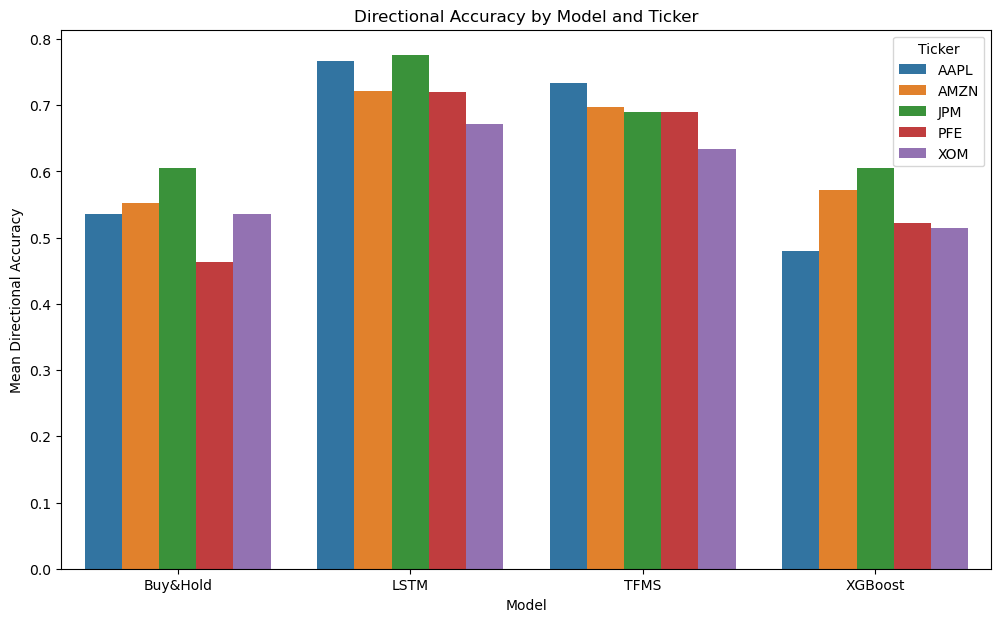

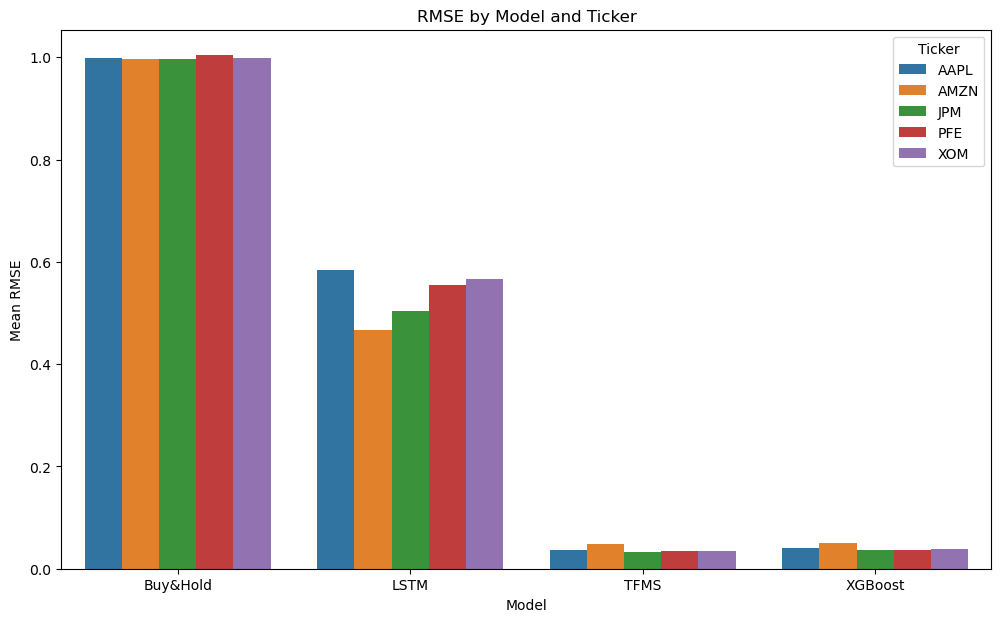

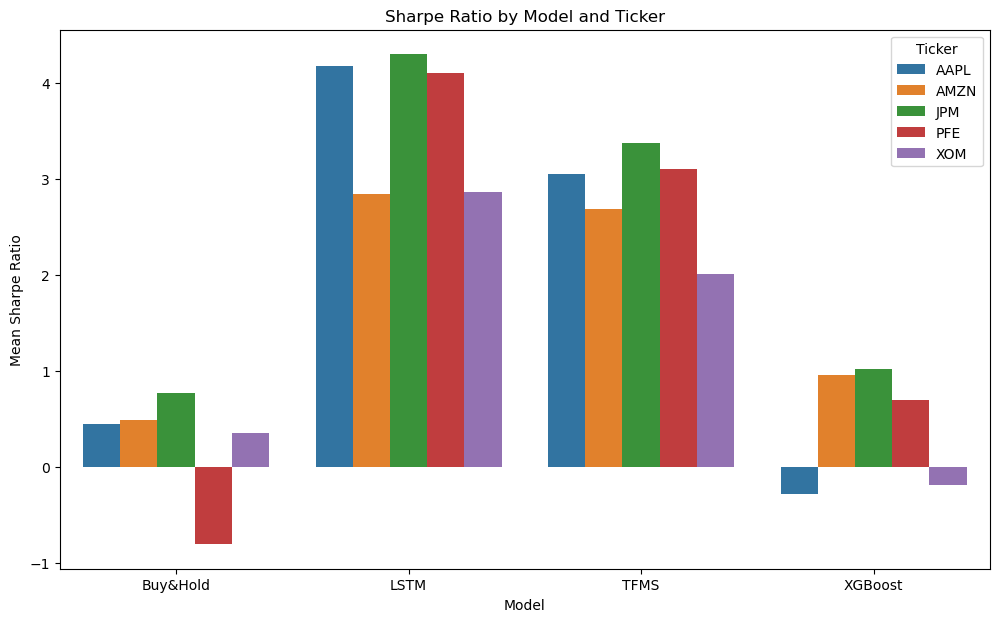

In [7]:
plt.figure(figsize=(12,7))
sns.barplot(data=summary, x="model", y="Acc_mean", hue="ticker")
plt.title("Directional Accuracy by Model and Ticker")
plt.ylabel("Mean Directional Accuracy")
plt.xlabel("Model")
plt.legend(title="Ticker")
plt.show()

plt.figure(figsize=(12,7))
sns.barplot(data=summary, x="model", y="RMSE_mean", hue="ticker")
plt.title("RMSE by Model and Ticker")
plt.ylabel("Mean RMSE")
plt.xlabel("Model")
plt.legend(title="Ticker")
plt.show()

plt.figure(figsize=(12,7))
sns.barplot(data=summary, x="model", y="Sharpe_mean", hue="ticker")
plt.title("Sharpe Ratio by Model and Ticker")
plt.ylabel("Mean Sharpe Ratio")
plt.xlabel("Model")
plt.legend(title="Ticker")
plt.show()


In [8]:
# Pivot for single-table view (accuracy only, but you can add RMSE/Sharpe)
accuracy_table = summary.pivot(index="ticker", columns="model", values="Acc_mean")
print("Summary Table: Test Mean Directional Accuracy by Model")
display(accuracy_table)


Summary Table: Test Mean Directional Accuracy by Model


model,Buy&Hold,LSTM,TFMS,XGBoost
ticker,,,,
AAPL,0.535403,0.767190,0.733789,0.479236
AMZN,0.552284,0.721333,0.697864,0.572108
JPM,0.605373,0.775182,0.689678,0.605373
PFE,0.463817,0.720116,0.689640,0.521505
XOM,0.535081,0.671413,0.634007,0.514156
